# Prometheus Anomaly Detection
This notebook will give an introduction to how we can perform anomaly detection for Prometheus metrics using a machine learning time series forecasting model. 

## What is an anomaly?
Prometheus is the chosen application to do monitoring across multiple products and platforms. Prometheus metrics are time series data identified by metric name and key/value pairs. With the increased amount of metrics flowing in it is getting harder to see the signals within the noise. The current state of the art is to graph out metrics on dashboards and alert on thresholds. However, we can leverage machine learning algorithms to perform time series forecasting and predict an unusual behavior or pattern in the metrics. The predicted values from the model can be compared with the actual metric values and if they differ from the default threshold values, we can flag it as an anomaly.

The notebook will walk through the essential steps required for training a machine learning model to predict anomalies on a sample Prometheus time series metrics data set:

## Data Prepration
* Load sample metric data set (Json)
* Convert the raw metric data into suitable pandas dataframe using the Prometheus API client
* Compress the timeseries into suitable (1h/ 0.5h/ 0.25/) frequency for training the model

## Data Modelling
* Train a ML model with the required hyperparameters
* Forecast the predictions on a test data set
* Evaluate the predictions for detecting anomalies

Let's install the required packages/modules

In [373]:
!pip3 install prometheus-api-client

In [374]:
import os
import time
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import math

import json as JS
from json import load
from json import loads
from datetime import datetime
#from fbprophet import Prophet

from pmdarima.arima import auto_arima
import statsmodels.api as sm
import mlflow
import mlflow.sklearn
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas.io.json import json_normalize
from pandas.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters
from prometheus_api_client import Metric, MetricsList, PrometheusConnect
from prometheus_api_client.utils import parse_datetime, parse_timedelta

## Data Preparation

### Load and Explore Time Series Data

The dataset we will be using are Prometheus read/write metrics collected from a Dgraph application. Prometheus is an open source application monitoring tool that has a time series database for storing time series metrics. Each metric is associated with a timestamp and a corresponding value. Every metric consists of a metric name and additional labels which provide more details about the metric. For eg: http_requests_total{job="apiserver", handler="/api/comments"}
   - **Metric Name**: *http_requests_total*
   - **Labels**: *{job="apiserver", handler="/api/comments"}*

Here we are loading the dataset that containes the past 90 days of disk write metrics.

In [379]:
raw_data = pd.read_json("metrics/prometheus-route-aiops-prod-prometheus-predict.cloud.paas.psi.redhat.com/badger_disk_writes:rate1m/90 days of data/201910081557.json")

In [380]:
#display the first few lines of the data
raw_data.head()

,metric,values
0,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1562788680.825, 0], [1562788740.825, 0], [15..."
1,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1562788680.825, 0], [1562788740.825, 0], [15..."
2,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1562788680.825, 0], [1562788740.825, 0], [15..."
3,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1562788680.825, 0], [1562788740.825, 0], [15..."
4,"{'__name__': 'badger_disk_writes:rate1m', 'ae_...","[[1565236860.825, 0], [1565236920.825, 0], [15..."


Let's understand the structure of the `data`

In [381]:
print(type(raw_data))
print(len(raw_data))

<class 'pandas.core.frame.DataFrame'>
12


### Data Pre-Processing

The raw data obtained from Prometheus is not very easy to understand nor is a suitable input for a machine learning model. To convert this raw data into an easier format we will make use of the Prometheus API Client.

The Prometheus API client has a `MetricsList` object that creates a list of `Metric` objects, where each object is unique for a specific time-series. You can find more details about this here: https://prometheus-api-client-python.readthedocs.io/source/prometheus_api_client.html

We will first convert the raw data into a `list` format as this is the input type required by the `MetricsList` function.

In [384]:
metric_data = raw_data.to_dict('records')

In [385]:
type(metric_data)

list

Now we can intitalize a `MetricsList` object.

In [386]:
metrics_object_list = MetricsList(metric_data)

In [387]:
print(len(metrics_object_list))
print(type(metrics_object_list))

12
<class 'prometheus_api_client.metrics_list.MetricsList'>


Let's look at one of the items in this `MetricsList` object created.

In [388]:
m = metrics_object_list[0]
print(m)

{
metric_name: 'badger_disk_writes:rate1m'
label_config: {'ae_source': 'http://prometheus-exporter-zero-0.thoth-dgraph-stage.svc:8080/debug/prometheus_metrics', 'instance': 'prometheus-aggregate-exporter-thoth-dgraph-stage.cloud.paas.psi.redhat.com:80', 'job': 'Thoth Dgraph aggregate-exporter (stage)', 'monitor': 'datahub'}
metric_values:                                   ds    y
0      2019-07-10 19:58:00.825000048  0.0
1      2019-07-10 19:59:00.825000048  0.0
2      2019-07-10 20:00:00.825000048  0.0
3      2019-07-10 20:01:00.825000048  1.7
4      2019-07-10 20:02:00.825000048  0.0
5      2019-07-10 20:03:00.825000048  0.0
6      2019-07-10 20:04:00.825000048  0.0
7      2019-07-10 20:05:00.825000048  0.0
8      2019-07-10 20:06:00.825000048  0.0
9      2019-07-10 20:07:00.825000048  0.0
10     2019-07-10 20:08:00.825000048  0.0
11     2019-07-10 20:09:00.825000048  0.0
12     2019-07-10 20:10:00.825000048  0.0
13     2019-07-10 20:11:00.825000048  0.0
14     2019-07-10 20:12:00.82

We see that the Metric object has the following 3 properties.

They are,

* **metric_name**: stores the name of the metric as a string

* **label_config**: stores metric labels and values as a dict

* **metric_values**: metric values as a pandas dataframe

However, we are only interested in the `metric_values` as this contains the timestamp and its corresponding metric value for which we want to train our machine learning model. So, lets extract only the metric values....

In [391]:
m_values = m.metric_values
print(type(m_values))
print(m_values)

<class 'pandas.core.frame.DataFrame'>
                                  ds    y
0      2019-07-10 19:58:00.825000048  0.0
1      2019-07-10 19:59:00.825000048  0.0
2      2019-07-10 20:00:00.825000048  0.0
3      2019-07-10 20:01:00.825000048  1.7
4      2019-07-10 20:02:00.825000048  0.0
5      2019-07-10 20:03:00.825000048  0.0
6      2019-07-10 20:04:00.825000048  0.0
7      2019-07-10 20:05:00.825000048  0.0
8      2019-07-10 20:06:00.825000048  0.0
9      2019-07-10 20:07:00.825000048  0.0
10     2019-07-10 20:08:00.825000048  0.0
11     2019-07-10 20:09:00.825000048  0.0
12     2019-07-10 20:10:00.825000048  0.0
13     2019-07-10 20:11:00.825000048  0.0
14     2019-07-10 20:12:00.825000048  0.0
15     2019-07-10 20:13:00.825000048  0.0
16     2019-07-10 20:14:00.825000048  0.0
17     2019-07-10 20:15:00.825000048  0.0
18     2019-07-10 20:16:00.825000048  0.0
19     2019-07-10 20:17:00.825000048  0.0
20     2019-07-10 20:18:00.825000048  0.0
21     2019-07-10 20:19:00.825000048  

### Data Sampling
As you can see, this data consists of metric values that are generated per **minute**, resulting in a large number of data points which may take a considerate amount of time when training the model. Hence, we will compress this data to a **daily** frequency for the purpose of this workshop.

In [394]:
freq = '1d' # Here we are setting the frequency to daily, but we can also set this to be hourly or half-hourly etc

#Converting the dataframe to a single column with the timestamp column set as index
m_values = m_values.set_index('ds')

m_values = m_values.resample(freq).mean()
m_values = m_values.dropna()

Let's now look at the compressed data.

In [395]:
print(len(m_values))
print(m_values)

78
                    y
ds                   
2019-07-10   4.129030
2019-07-11   2.707075
2019-07-12   0.000000
2019-07-13   0.000000
2019-07-14   0.005729
2019-07-15  10.461936
2019-07-16   9.680335
2019-07-17  30.826611
2019-07-18  13.923609
2019-07-19   1.681819
2019-07-20   1.686718
2019-07-21   1.692917
2019-07-22   2.861460
2019-07-23   2.128386
2019-07-24   1.904082
2019-07-25   3.456007
2019-07-26   2.114877
2019-07-27   1.675417
2019-07-28   1.686111
2019-07-29   2.305088
2019-07-30   3.152909
2019-07-31   2.579170
2019-08-01   2.146685
2019-08-02   2.513906
2019-08-03   1.741598
2019-08-04   3.052006
2019-08-05   2.520001
2019-08-06   2.928711
2019-08-07   0.460608
2019-08-08   1.848317
...               ...
2019-08-27   1.788355
2019-08-28   1.787617
2019-08-29   1.673747
2019-08-30   1.688683
2019-08-31   1.725212
2019-09-01   1.712382
2019-09-02   1.927222
2019-09-03   1.722292
2019-09-04   1.711245
2019-09-05   1.689259
2019-09-06   1.711501
2019-09-07   1.675469
2019-09

We now have a much smaller dataset that we can look at. For trainign any machine learning model, we need to first split the data into `training` and `testing` datasets. 

* **Training** - The actual dataset that we use to train the model. The model sees and learns from this data.
* **Testing** - The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset

Now that you know what these datasets do, we will split the dataset into Train and Test sets. 

In [408]:
def split_data(dataframe):
    #Dividing the data set into (80%)training and (20%)testing samples
    dataframe = dataframe.sort_values(by = 'ds')
    ratio = 0.2
    size = int(len(dataframe) * (1-float(ratio)))
    train, test = dataframe[0:size], dataframe[size:len(dataframe)]
    return train, test

In [409]:
train, test = split_data(m_values)

In [410]:
print(len(train))
print(len(test))

62
16


## Data Modelling
We are now ready to train a time seriers forecasting model. Here, we will train the SARIMA model i.e. Seasonal Auto-Regressive Moving Average model.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series. There are three **trend** elements that require configuration. These are the ones that are configured in the standard ARIMA model.

* **p** - Trend autoregression order
* **d** - Trend difference order
* **q** - Trend moving average order

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

* **P**: Seasonal autoregressive order.
* **D**: Seasonal difference order.
* **Q**: Seasonal moving average order.
* **m**: The number of time steps for a single seasonal period.

**Note: To make things easier for you, we have already identified the optimized parameter values required to train the model for this particular dataset.**

In [411]:
def _sarima(train, test, freq):
    sfrequency = 0
    if freq == '1h':
        sfrequency = 24
    elif freq == '30Min':
        sfrequency = 48
    elif freq == '15Min':
        sfrequency = 96
    elif freq == '1d':
        sfrequency = 1
        
    model = SARIMAX(train, order=(1, 2, 2), seasonal_order=(2,2,2,sfrequency), enforce_stationarity = True, enforce_invertibility = False)
    model_fit = model.fit(dsip=-1)
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    print("Now plotting the residual errors for the SARIMA model")
    plt.show()
    residuals.plot(kind='kde')
    print("Now plotting the desity of the residual error values.")
    plt.show()
    print(residuals.describe())
    K = len(test)

    forecast = model_fit.forecast(K)
    # forecast = np.exp(forecast)
    forecast = pd.DataFrame(forecast.values, columns = ['predict'], index = test.index)

    plt.plot(forecast, label='forecast')
    plt.show()
    plt.figure(figsize=(12,5), dpi=100)
    # plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(forecast, label='forecast')
    # plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return model, model_fit, forecast

An important parameter to identify for the SARIMA model, is the **seasonality** frequency of the data. Seasonality is the presence of any predictable fluctuation or pattern that recurs/repeats over regular intervals. For example, data with daily observations might have a weekly seasonality (frequency=7) or an annual seasonality (frequency=365.25). Similarly, data that are observed every minute might have an hourly seasonality (frequency=60), a daily seasonality (frequency=24x60=1440), a weekly seasonality (frequency=24x60x7=10080) and an annual seasonality (frequency=24x60x365.25=525960).

The raw data obtained from Prometheus for the disk write metric was observed every minute and had a **daily** seasonality.

/home/hemaveeradhi/.local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Now plotting the residual errors for the SARIMA model


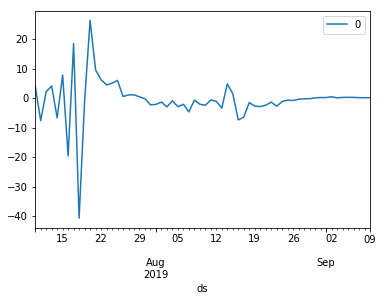

Now plotting the desity of the residual error values.


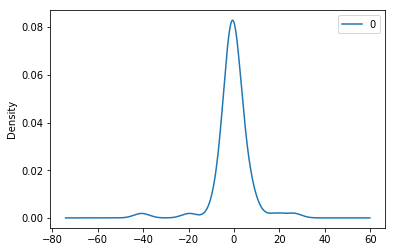

               0
count  62.000000
mean   -0.459958
std     7.808883
min   -40.664493
25%    -2.205185
50%    -0.282247
75%     0.559985
max    26.365492


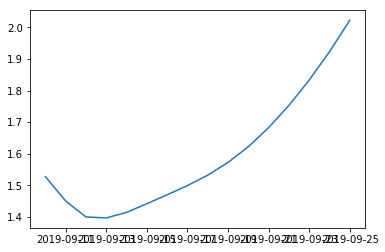

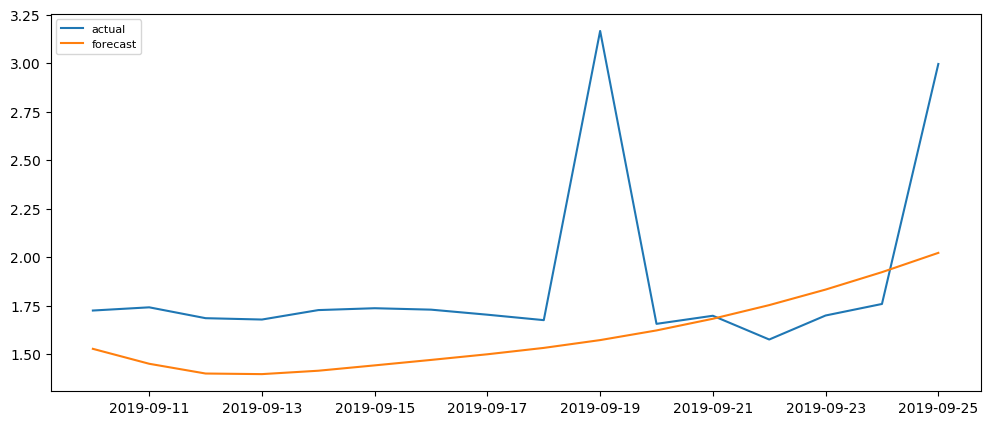

In [412]:
freq = '1d'
model, model_fit, forecast = _sarima(train, test, freq)

## Model Evaluation
Now that the model has successfully completed training, let's identify anomalies by comparing the `predicted` values with the `actual` values. To do so, we will define `upper` and `lower` bounds based on the range of predictions made by the model. If the actual metric value does not lie within these defined bounds, we will flag that as an anomaly.

In [417]:
def evaluation(forecast, test):
    upper_bound = np.array(
      [
        (
         float(np.ma.average(forecast[:i], axis = 0,weights=np.linspace(0, 1, num=len(forecast[:i]))))
          + (np.std(forecast[:i]) * 2)
        )
        for i in range(len(forecast))
        ]
    )
      # to account for no std of a single value
    lower_bound = np.array(
      [
        (
          float(np.ma.average(
            forecast[:i],axis = 0,
            weights=np.linspace(0, 1, num=len(forecast[:i])),))
          - (np.std(forecast[:i]) * 2)
        )
        for i in range(len(forecast))
        ]
    )

    compare = test.join(forecast, how = 'outer')
    compare = compare.dropna()
    lower = pd.DataFrame(lower_bound, columns = [0], index = test.index)
    upper = pd.DataFrame(upper_bound, columns = [0], index = test.index)

    compare.insert(2, "LowerBound", lower, True)
    compare.insert(3, "UpperBound", upper, True)
    compare['WithinUpperBounds'] = compare['predict'] < compare['UpperBound']
    compare['WithinLowerBounds'] = compare['predict'] > compare['LowerBound']
    
    #Detecting anomalies
    anomaly = []
    for i in range(len(compare)):
        if((compare['y'][i] < compare['UpperBound'][i]) and (compare['y'][i] > compare['LowerBound'][i])):
            anomaly.append(0)
        else:
            anomaly.append(1)
    
    compare.insert(6, "Anomaly", anomaly, True)
    print("The final dataframe with lowerbound, upperbound and prediction value:\n")
    print(compare)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(compare['predict'], label='Predicted')
    plt.plot(compare['LowerBound'], label='LowerBound')
    plt.plot(compare['UpperBound'], label='UpperBound')
    plt.plot(compare['y'], label='Actual')
    # plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

The final dataframe with lowerbound, upperbound and prediction value:

                   y   predict  LowerBound  UpperBound  WithinUpperBounds  \
ds                                                                          
2019-09-10  1.724981  1.527487         NaN         NaN              False   
2019-09-11  1.741487  1.450419         NaN         NaN              False   
2019-09-12  1.685489  1.400135    1.373352    1.527487               True   
2019-09-13  1.678527  1.397091    1.312150    1.521642               True   
2019-09-14  1.727260  1.414578    1.301468    1.512519               True   
2019-09-15  1.736840  1.442162    1.312794    1.507261               True   
2019-09-16  1.729479  1.470302    1.331922    1.509557               True   
2019-09-17  1.703437  1.499430    1.349738    1.520061               True   
2019-09-18  1.675417  1.532280    1.363108    1.538957               True   
2019-09-19  3.166596  1.572549    1.371449    1.566726              False   
2019-

/home/hemaveeradhi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Warning: converting a masked element to nan.
  
/home/hemaveeradhi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.


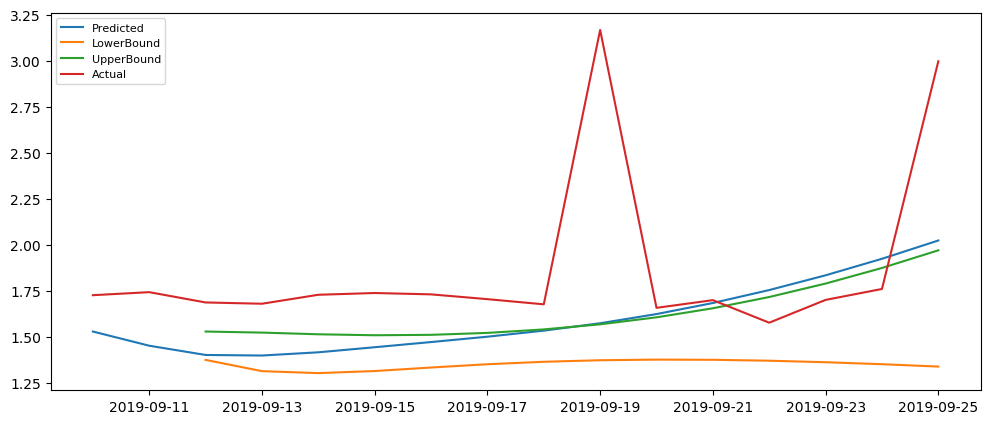

In [418]:
evaluation(forecast, test)